In [1]:
# pip install wordcloud
# pip install textblob

import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from keras.models import Sequential
from keras.optimizers import Adam
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
data = pd.read_csv('Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [6]:
data.groupby('class').size().reset_index(name='counts')

,class,counts
0,non-suicide,116037
1,suicide,116037


<AxesSubplot:xlabel='class', ylabel='count'>

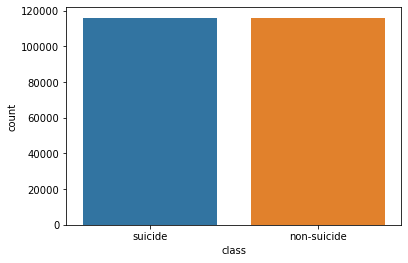

In [7]:
sns.countplot(x=data['class'])

<AxesSubplot:ylabel='class'>

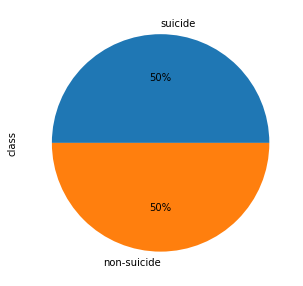

In [8]:
data['class'].value_counts().plot(kind='pie', autopct='%1.0f%%',figsize=(5,5))

In [9]:
data.duplicated().sum()

0

In [10]:
data= data.drop_duplicates()

In [11]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def remove_noise(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on text column
data['cleaned']=data['text'].apply(remove_noise)

In [12]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

data['cleaned']=data['cleaned'].apply(clean_text)

In [13]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on cleaned column
data['cleaned']=data['cleaned'].apply(remove_special_characters)

In [14]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function on cleaned column
data['cleaned']=data['cleaned'].apply(simple_stemmer)

In [15]:
#set stopwords to english

nltk.download('stopwords')
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on cleaned column
data['cleaned']=data['cleaned'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to C:\Users\Afrime
[nltk_data]     Araf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'because', 'just', 'his', "that'll", 'herself', "she's", 'being', 'down', 'were', 'these', 'won', "isn't", 'll', 'himself', 'any', 'few', 'he', 's', 'having', 'no', 'through', "should've", 'shouldn', 'o', "doesn't", 'mightn', 'their', 'both', 'further', 'very', 'above', 'yourself', 'hasn', 'this', 'until', "you'll", 'below', 'against', 'most', 'here', "you're", 'about', 'the', "wouldn't", 'why', 'did', 'theirs', 'than', 'mustn', 'wouldn', 'hers', 've', 'me', 'before', "shan't", 'out', 'so', 'only', "mustn't", 'ma', 'after', 'such', 'then', 'and', "it's", 'themselves', 'her', 'needn', 'what', 'own', 'do', 'into', 'but', "won't", 'as', 'by', 'be', 'again', 'up', 'nor', 'aren', "didn't", 'of', 'ourselves', 'they', 'during', 'how', 'was', 'from', 'has', 'ain', 'weren', 'in', 'an', 'when', 'some', 'if', 'yours', 'not', 'for', 'itself', 'whom', 'had', 'same', "couldn't", 'should', 'doesn', "needn't", 'while', 'now', 'don', 'she', 'y', 'am', 'at', 'there', 'been', 'is', 'have', 'doing', 'wil

In [16]:
# Remove the Text with least words
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
dataset = data.loc[data.length>0]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Text".format(len(data)-len(dataset)),
      "\nTotal Text:",len(dataset))

After Cleaning: 
Removed 69 Small Text 
Total Text: 232005


In [17]:
data

,Unnamed: 0,text,class,cleaned,length
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threaten suiciderec left wife good bec...,67
1,3,Am I weird I don't get affected by compliments...,non-suicide,weird get affect compliment come someon know i...,13
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,final 2020 almost never hear 2020 ha bad year ...,14
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help im cri hard,6
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,im losthello name adam 16 ive struggl year im ...,243
...,...,...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide,like rock go get anyth thi go httpsmusictast s...,10
232070,348106,You how you can tell i have so many friends an...,non-suicide,tell mani friend lone everyth depriv prebought...,14
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probabl tast like salti tea someon drank p...,12
232072,348108,The usual stuff you find hereI'm not posting t...,suicide,usual stuff find herei post thi sympathi piti ...,160


In [18]:
dataset.groupby('class').size().reset_index(name='counts')

,class,counts
0,non-suicide,115978
1,suicide,116027


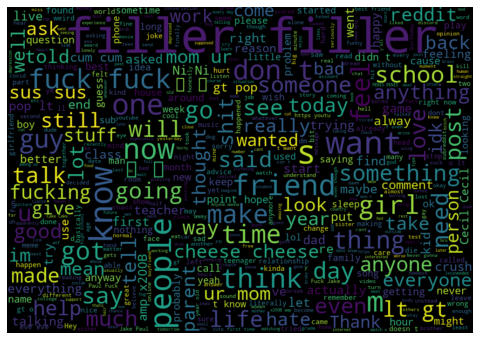

In [19]:
# Plot the positive Word Cloud
pos_df = dataset[dataset['class'] == 'non-suicide']
positive_text = ' '.join([comnt for comnt in pos_df['text']])

WC=WordCloud(width=1000,height=700,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)

fig = plt.figure(1, figsize=(10, 6))
plt.imshow(positive_words, interpolation = "bilinear")
plt.axis('off')
plt.show()

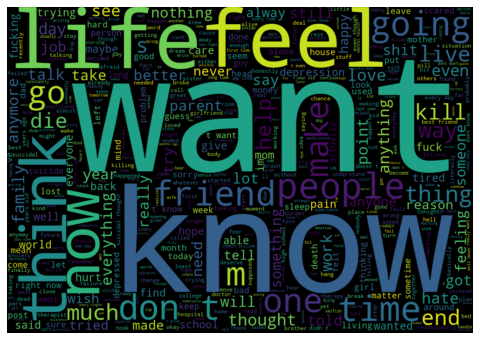

In [20]:
# Plot the negative Word Cloud
neg_df = dataset[dataset['class'] == 'suicide']
negative_text = ' '.join([comnt for comnt in neg_df['text']])

WC=WordCloud(width=1000,height=700,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)

fig = plt.figure(1, figsize=(10, 6))
plt.imshow(negative_words, interpolation = "bilinear")
plt.axis('off')
plt.show()

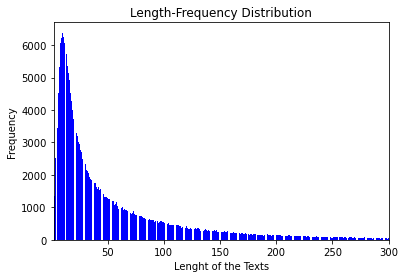

Maximum Length of a Text: 5850
Minimum Length of a Text: 1
Average Length of a Text: 66.0


In [21]:
# Calculate the Text of each of the Text
dataset['TextLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.TextLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(2, 300)
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a Text: {max(dataset.TextLength)}")
print(f"Minimum Length of a Text: {min(dataset.TextLength)}")
print(f"Average Length of a Text: {round(np.mean(dataset.TextLength),0)}")

In [22]:
texts = dataset['cleaned'].values
labels = dataset['class'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels,test_size = 0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(185604,) (46401,) (185604,) (46401,)


In [24]:
vocab_size = 30000
embedding_dim = 500
max_length = 5850
trunc_type = 'post'
padding_type = 'post'

In [25]:
#Tokenization
tokenizer = Tokenizer(num_words = vocab_size, split = (' '))
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [26]:
#Padding

X_train = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train, padding='post', maxlen=max_length)

X_test = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test, padding='post', maxlen=max_length)

In [27]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5850, 500)         15000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 5846, 128)         320128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 15,321,429
Trainable params: 15,321,429
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(X_train_padded, 
                    y_train, epochs=10, 
                    verbose=1,
                    steps_per_epoch = len(X_train)/256,
                    batch_size = 32,
                    validation_split=0.2)

Epoch 1/10
725/725 [==============================] - 213s 282ms/step - loss: 0.2501 - accuracy: 0.9030 - val_loss: 0.1998 - val_accuracy: 0.9233
Epoch 2/10
725/725 [==============================] - 196s 271ms/step - loss: 0.1941 - accuracy: 0.9241 - val_loss: 0.1892 - val_accuracy: 0.9262
Epoch 3/10
725/725 [==============================] - 197s 271ms/step - loss: 0.1878 - accuracy: 0.9293 - val_loss: 0.1775 - val_accuracy: 0.9327
Epoch 4/10
725/725 [==============================] - 196s 271ms/step - loss: 0.1785 - accuracy: 0.9329 - val_loss: 0.1720 - val_accuracy: 0.9350
Epoch 5/10
725/725 [==============================] - 196s 271ms/step - loss: 0.1617 - accuracy: 0.9411 - val_loss: 0.1693 - val_accuracy: 0.9358
Epoch 6/10
725/725 [==============================] - 196s 270ms/step - loss: 0.1694 - accuracy: 0.9353 - val_loss: 0.1680 - val_accuracy: 0.9353
Epoch 7/10
725/725 [==============================] - 198s 273ms/step - loss: 0.1323 - accuracy: 0.9499 - val_loss: 0.1772 -

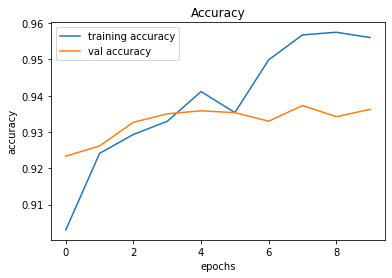

In [29]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

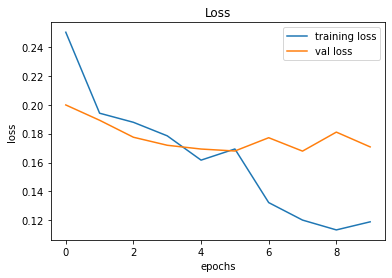

In [30]:
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [31]:
prediction = model.predict(X_test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
y_pred = []
for i in prediction:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
print("Accuracy of prediction on test set : ", accuracy_score(y_test,y_pred))

Accuracy of prediction on test set :  0.9386866662356415


In [32]:
class_names = ['suicide','non-suicide']

In [33]:
cf = classification_report(y_test,y_pred, target_names = class_names)
print(cf)

              precision    recall  f1-score   support

     suicide       0.93      0.95      0.94     23264
 non-suicide       0.95      0.93      0.94     23137

    accuracy                           0.94     46401
   macro avg       0.94      0.94      0.94     46401
weighted avg       0.94      0.94      0.94     46401



In [34]:
cm = confusion_matrix(y_test,y_pred)

cm_df = pd.DataFrame(cm, index = class_names,
                     columns = class_names
                    )

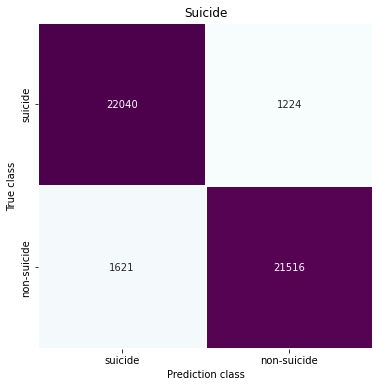

In [35]:
plt.figure(figsize = (6,6))
sns.heatmap(cm_df, annot = True,cmap='BuPu',cbar=False,linewidth=2,fmt='d')
plt.title('Suicide')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()